# Network Flow Data Cleaning
This notebook cleans network flow data by standardizing direction values and removing duplicates.

## 0. Import Libraries & uploading dataset

In [2]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Uploading the dataset
path = "../data"
filename = "capture20110810.csv"
fullpath = os.path.join(path, filename)

data1 = pd.read_csv(fullpath, sep=",")
data1['sTos'] = data1['sTos'].astype('Int64')
data1['dTos'] = data1['dTos'].astype('Int64')

print("Shape", data1.shape)

path = "../data"
filename = "capture20110811.csv"
fullpath = os.path.join(path, filename)

data2 = pd.read_csv(fullpath, sep=",")
data2['sTos'] = data2['sTos'].astype('Int64')
data2['dTos'] = data2['dTos'].astype('Int64')

print("Shape", data2.shape)

data = pd.concat([data1, data2], ignore_index=True)
print("Shape", data.shape)

Shape (2824636, 15)
Shape (1808122, 15)
Shape (4632758, 15)


## 1. Checking and fixing bad labels

In [10]:
# Check unique values in the Dir column
print("Unique direction values:")
print(data['Dir'].value_counts())

# Remove any whitespace
data['Dir'] = data['Dir'].str.strip()

# Drop row with invalid 'Dir' value: 'who'
data = data[data['Dir'] != 'who']

# Swap position of SrcAddr / DstAddr and Sport / Dport when Dir is '<-' or '<?'
mask = data['Dir'].isin(['<-', '<?'])
data.loc[mask, ['SrcAddr', 'DstAddr']] = data.loc[mask, ['DstAddr', 'SrcAddr']].values
data.loc[mask, ['Sport', 'Dport']] = data.loc[mask, ['Dport', 'Sport']].values


# Substitution of bad tokens in 'Dir' column and labeling:
    # ?>, ->, <? and <-    in  'mono'  as monodirectional flow
    # <?> and <->          in  'bi'    as bidirectional flow
data['Dir'] = data['Dir'].str.strip()   # Remove any whitespace
data['Dir'] = data['Dir'].replace({
        '->': 'mono',
        '?>': 'mono',
        '<-': 'mono',
        '<?': 'mono',
        '<->': 'bi',
        '<?>': 'bi'
    })


# Check unique values in the Dir column after cleaning
print("\nUnique direction values after cleaning:")
print(data['Dir'].value_counts())

 


Unique direction values:
Dir
bi      3487531
mono    1144404
Name: count, dtype: int64

Unique direction values after cleaning:
Dir
bi      3487531
mono    1144404
Name: count, dtype: int64


# 2. Removing Duplicates

In [6]:
# Check number of duplicates and remove them
duplicateRows = data.duplicated().sum()
print("Numero di duplicati: ", duplicateRows)
if duplicateRows > 0:
    nodup_dff = data.drop_duplicates()
    print("New shape after removing duplicates: ", nodup_dff.shape)

Numero di duplicati:  0


# 3. Drop not useful columns

In [7]:
# Check unique values in the Dir column
print("Unique sTos and dTos values:")
sTos_values = data['sTos'].value_counts(dropna=False)
dTos_values = data['dTos'].value_counts(dropna=False)

sTos_valid_non_zero_mask = (sTos_values.index != 0) & (sTos_values.index.notna())
sTos_non_zero = sTos_values[sTos_valid_non_zero_mask].sum()
sTos_perc = sTos_non_zero/data.shape[0] * 100

dTos_valid_non_zero_mask = (dTos_values.index != 0) & (dTos_values.index.notna())
dTos_non_zero = dTos_values[dTos_valid_non_zero_mask].sum()
dTos_perc = dTos_non_zero/data.shape[0] * 100

print(f"Non-zero, non-NaN sTos occurrences: {sTos_non_zero}, \tfor {sTos_perc:.2f}% of the total dataset.")
print(f"Non-zero, non-NaN dTos occurrences: {dTos_non_zero}, \tfor {dTos_perc:.2f}% of the total dataset.")



Unique sTos and dTos values:
Non-zero, non-NaN sTos occurrences: 5478, 	for 0.12% of the total dataset.
Non-zero, non-NaN dTos occurrences: 726, 	for 0.02% of the total dataset.


In [20]:
# Drop sTos and dTos since are a minimum part of the dataset
cols_to_drop = ['sTos', 'dTos']
data.drop(columns=[c for c in cols_to_drop if c in data.columns], inplace=True, axis=1)
print(data.shape)

(1807780, 13)


# 4. Uniform labels into *botnet* (1) and *no botnet* (0)

In [21]:
# We use a lambda function to check if "botnet" is in the string (case insensitive)
# If 'botnet' appears -> 1. Everything else (Background, Safe, Normal) -> 0
data['Label'] = data['Label'].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
print(data['Label'].value_counts())
print(data.head())

Label
0    1786839
1      20941
Name: count, dtype: int64
                    StartTime       Dur Proto       SrcAddr  Sport   Dir  \
0  2011/08/11 09:53:40.240135  9.016532   tcp  31.96.153.11  60257  mono   
1  2011/08/11 09:55:01.054702  2.903761   tcp  83.228.37.92   2571  mono   
2  2011/08/11 09:55:02.677188  3.032142   tcp  83.228.37.92   2574  mono   
3  2011/08/11 09:55:04.307051  2.932428   tcp  83.228.37.92   2576  mono   
4  2011/08/11 09:55:03.958463  6.017523   tcp  83.228.37.92   2571  mono   

         DstAddr  Dport   State  TotPkts  TotBytes  SrcBytes  Label  
0  147.32.84.229    443  SRA_SA        7       508       208      0  
1  147.32.84.229  13363   SR_SA        3       184       122      0  
2  147.32.84.229    443   SR_SA        3       184       122      0  
3  147.32.84.229     80   SR_SA        3       184       122      0  
4  147.32.84.229  13363   SR_SA        3       184       122      0  


## 5. Save cleaned dataset
Specify an output file path.

In [22]:
# When saving file with same name, it overwrites the original one.
new_filename = "cleaned_" + filename
new_path = os.path.join(path, new_filename)

data.to_csv(new_path, index=False)
print(f"Original path: {path}")
print(f"Saved cleaned data to: {new_path}")

Original path: ../data
Saved cleaned data to: ../data/cleaned_capture20110811.csv


In [23]:
# Display the first few rows of the cleaned data
data

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/11 09:53:40.240135,9.016532,tcp,31.96.153.11,60257,mono,147.32.84.229,443,SRA_SA,7,508,208,0
1,2011/08/11 09:55:01.054702,2.903761,tcp,83.228.37.92,2571,mono,147.32.84.229,13363,SR_SA,3,184,122,0
2,2011/08/11 09:55:02.677188,3.032142,tcp,83.228.37.92,2574,mono,147.32.84.229,443,SR_SA,3,184,122,0
3,2011/08/11 09:55:04.307051,2.932428,tcp,83.228.37.92,2576,mono,147.32.84.229,80,SR_SA,3,184,122,0
4,2011/08/11 09:55:03.958463,6.017523,tcp,83.228.37.92,2571,mono,147.32.84.229,13363,SR_SA,3,184,122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808117,2011/08/11 14:01:11.251391,0.000000,tcp,61.147.68.190,1841,mono,147.32.85.100,3126,S_,1,62,62,0
1808118,2011/08/11 14:01:11.251890,0.000000,udp,60.242.212.221,44024,mono,147.32.84.229,13363,INT,1,79,79,0
1808119,2011/08/11 14:01:11.252608,0.000000,udp,31.29.169.200,5924,mono,147.32.84.229,13363,INT,1,77,77,0
1808120,2011/08/11 14:01:11.256842,0.000000,tcp,147.32.84.59,1384,mono,67.63.146.250,443,S_,1,66,66,0


In [ ]:
# 1. Drop StartTime (Time-series data requires specific handling, for a general RF we drop it)
if 'StartTime' in data.columns:
    data = data.drop(columns=['StartTime'])

# 2. Separate Features (X) and Target (y)
y = data['Label']
X = data.drop(columns=['Label'])

# 3. Split Data
# We split BEFORE encoding to prevent "Data Leakage" (Test IPs shouldn't affect Train counts)
print("Splitting data (80% Train, 20% Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Splitting data (80% Train, 20% Test)...
Train shape: (1446224, 11)
Test shape:  (361556, 11)


In [25]:
# --- A. Label Encoding for Low Cardinality Columns ---
# (Proto, Dir, State) -> Mapped to integers (0, 1, 2...)
cat_cols = ['Proto', 'Dir', 'State']

print(f"Applying Label Encoding to: {cat_cols}")

for col in cat_cols:
    # We combine Train and Test just to get the full list of unique categories
    # to ensure the mapping is consistent (e.g., TCP is always 1), 
    # but we DO NOT use the test data to train the model.
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    
    # Generate codes
    codes, uniques = pd.factorize(combined)
    
    # Assign back to Train and Test correctly
    X_train[col] = codes[:len(X_train)]
    X_test[col] = codes[len(X_train):]


# --- B. Frequency Encoding for High Cardinality Columns ---
# (IPs, Ports) -> Mapped to "How active/popular is this value?"
freq_cols = ['SrcAddr', 'DstAddr', 'Sport', 'Dport']

print(f"Applying Frequency Encoding to: {freq_cols}")

for col in freq_cols:
    # 1. Calculate frequency ONLY on Training data
    # (normalize=True gives the percentage, e.g., 0.05 means 5% of traffic)
    freq_map = X_train[col].value_counts(normalize=True)
    
    # 2. Map the Training data
    X_train[col] = X_train[col].map(freq_map)
    
    # 3. Map the Test data
    # CRITICAL: If an IP appears in Test but not Train, fillna(0) marks it as "New/Unknown"
    X_test[col] = X_test[col].map(freq_map).fillna(0)

# Check if any non-numeric data remains
print("Encoding complete. Checking for non-numeric columns...")
print(X_train.dtypes)

Applying Label Encoding to: ['Proto', 'Dir', 'State']
Applying Frequency Encoding to: ['SrcAddr', 'DstAddr', 'Sport', 'Dport']
Encoding complete. Checking for non-numeric columns...
Dur         float64
Proto         int64
SrcAddr     float64
Sport       float64
Dir           int64
DstAddr     float64
Dport       float64
State         int64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
dtype: object


In [26]:
print("Initializing Random Forest...")

# We use class_weight='balanced' because Botnets are only a small % of data.
# n_jobs=-1 uses all CPU cores to speed up processing of 2M+ rows.
rf_model = RandomForestClassifier(
    n_estimators=50,       # Start with 50 trees for speed
    max_depth=20,          # Limit depth to prevent overfitting and save RAM
    n_jobs=-1, 
    random_state=42,
    class_weight='balanced',
    verbose=1
)

print("Training model... (This might take a few minutes)")
rf_model.fit(X_train, y_train)

print("Training complete.")

Initializing Random Forest...
Training model... (This might take a few minutes)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.3s


Training complete.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.7s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


--- Model Performance ---


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished



Confusion Matrix:
[[357368      0]
 [     0   4188]]

Classification Report:
                 precision    recall  f1-score   support

Background/Safe       1.00      1.00      1.00    357368
         Botnet       1.00      1.00      1.00      4188

       accuracy                           1.00    361556
      macro avg       1.00      1.00      1.00    361556
   weighted avg       1.00      1.00      1.00    361556



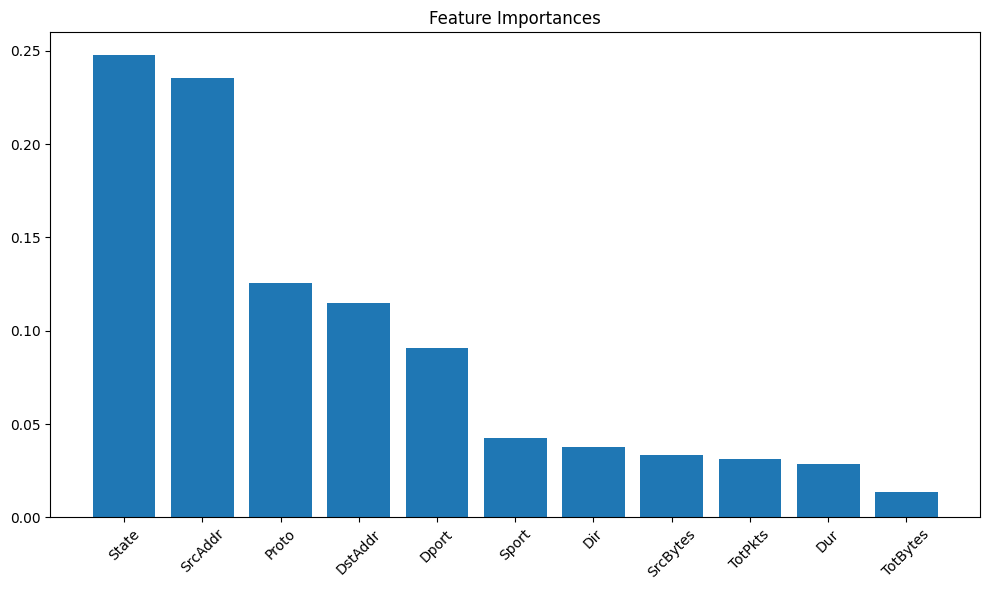

In [27]:
print("--- Model Performance ---")

# 1. Predict
y_pred = rf_model.predict(X_test)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 3. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background/Safe', 'Botnet']))

# 4. Feature Importance Plot 
# This helps you understand WHAT the botnet is actually doing
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.tight_layout()
plt.show()